In [8]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [9]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240614_train.csv')
test = pd.read_csv('../data/processed/processed20240614_test.csv')

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_mean,category_1_purchase_amount_mean,category_1_purchase_amount_min,category_1_purchase_amount_max,category_1_purchase_amount_std,installments_purchase_amount_mean,installments_purchase_amount_min,installments_purchase_amount_max,installments_purchase_amount_std,city_id_purchase_amount_mean,city_id_purchase_amount_min,city_id_purchase_amount_max,city_id_purchase_amount_std,category_1_installments_mean,category_1_installments_min,category_1_installments_max,category_1_installments_std
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.48

In [11]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [12]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [13]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)  # KFoldクラスを使ってデータを5分割し、ランダムにシャッフルしている
oof = np.zeros(len(train))  # trainデータの長さと同じだけのゼロの配列を作成している
predictions = np.zeros(len(test))  # testデータの長さと同じだけのゼロの配列を作成している
start = time.time()  # 処理の開始時間を記録している
feature_importance_df = pd.DataFrame()  # 特徴量の重要度を記録するための空のデータフレームを作成している

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    # KFoldで分割された各フォールドごとに処理を行う
    print("fold n°{}".format(fold_))  # 現在のフォールド番号を出力している
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], 
                           label=target.iloc[trn_idx], 
                           categorical_feature=categorical_feats
                          )  # トレーニングデータをLightGBMの形式に変換している
    val_data = lgb.Dataset(train.iloc[val_idx][features], 
                           label=target.iloc[val_idx], 
                           categorical_feature=categorical_feats
                          )  # 検証データをLightGBMの形式に変換している

    num_round = 10000  # 学習の最大繰り返し回数を設定している
    clf = lgb.train(params=param, 
                    train_set=trn_data, 
                    num_boost_round=num_round, 
                    valid_sets=[val_data], 
                    callbacks=[lgb.early_stopping(stopping_rounds=200), 
                               lgb.log_evaluation(100)])  # LightGBMのモデルを学習させている

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)  
    # 検証データに対して予測を行い、結果をoof配列に保存している
    
    fold_importance_df = pd.DataFrame()  # 各フォールドごとの特徴量重要度を記録するためのデータフレームを作成している
    fold_importance_df["feature"] = features  # 特徴量の名前を設定している
    fold_importance_df["importance"] = clf.feature_importance()  # 各特徴量の重要度を計算して設定している
    fold_importance_df["fold"] = fold_ + 1  # フォールド番号を設定している
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)  
    # 各フォールドの特徴量重要度をまとめている

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:  # モデルをpickle形式で保存している
        pickle.dump(clf, f)  # モデルオブジェクトをファイルに書き込んでいる

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))  
# クロスバリデーションのスコアを計算し、出力している


fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7763
[200]	valid_0's rmse: 3.7291
[300]	valid_0's rmse: 3.70582
[400]	valid_0's rmse: 3.6933
[500]	valid_0's rmse: 3.6862
[600]	valid_0's rmse: 3.68148
[700]	valid_0's rmse: 3.67848
[800]	valid_0's rmse: 3.67647
[900]	valid_0's rmse: 3.67532
[1000]	valid_0's rmse: 3.67438
[1100]	valid_0's rmse: 3.6736
[1200]	valid_0's rmse: 3.6733
[1300]	valid_0's rmse: 3.67271
[1400]	valid_0's rmse: 3.67264
[1500]	valid_0's rmse: 3.67236
[1600]	valid_0's rmse: 3.67227
[1700]	valid_0's rmse: 3.67223
[1800]	valid_0's rmse: 3.67215
[1900]	valid_0's rmse: 3.67221
Early stopping, best iteration is:
[1739]	valid_0's rmse: 3.67198
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70525
[200]	valid_0's rmse: 3.66192
[300]	valid_0's rmse: 3.64112
[400]	valid_0's rmse: 3.6305
[500]	valid_0's rmse: 3.62509
[600]	valid_0's rmse: 3.62215
[700]	valid_0's rmse: 3.62022
[800]	val

In [14]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.7763
[200]	valid_0's rmse: 3.7291
[300]	valid_0's rmse: 3.70582
[400]	valid_0's rmse: 3.6933
[500]	valid_0's rmse: 3.6862
[600]	valid_0's rmse: 3.68148
[700]	valid_0's rmse: 3.67848
[800]	valid_0's rmse: 3.67647
[900]	valid_0's rmse: 3.67532
[1000]	valid_0's rmse: 3.67438
[1100]	valid_0's rmse: 3.6736
[1200]	valid_0's rmse: 3.6733
[1300]	valid_0's rmse: 3.67271
[1400]	valid_0's rmse: 3.67264
[1500]	valid_0's rmse: 3.67236
[1600]	valid_0's rmse: 3.67227
[1700]	valid_0's rmse: 3.67223
[1800]	valid_0's rmse: 3.67215
[1900]	valid_0's rmse: 3.67221
Early stopping, best iteration is:
[1739]	valid_0's rmse: 3.67198
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.70525
[200]	valid_0's rmse: 3.66192
[300]	valid_0's rmse: 3.64112
[400]	valid_0's rmse: 3.6305
[500]	valid_0's rmse: 3.62509
[600]	valid_0's rmse: 3.62215
[700]	valid_0's rmse: 3.62022
[800]	val

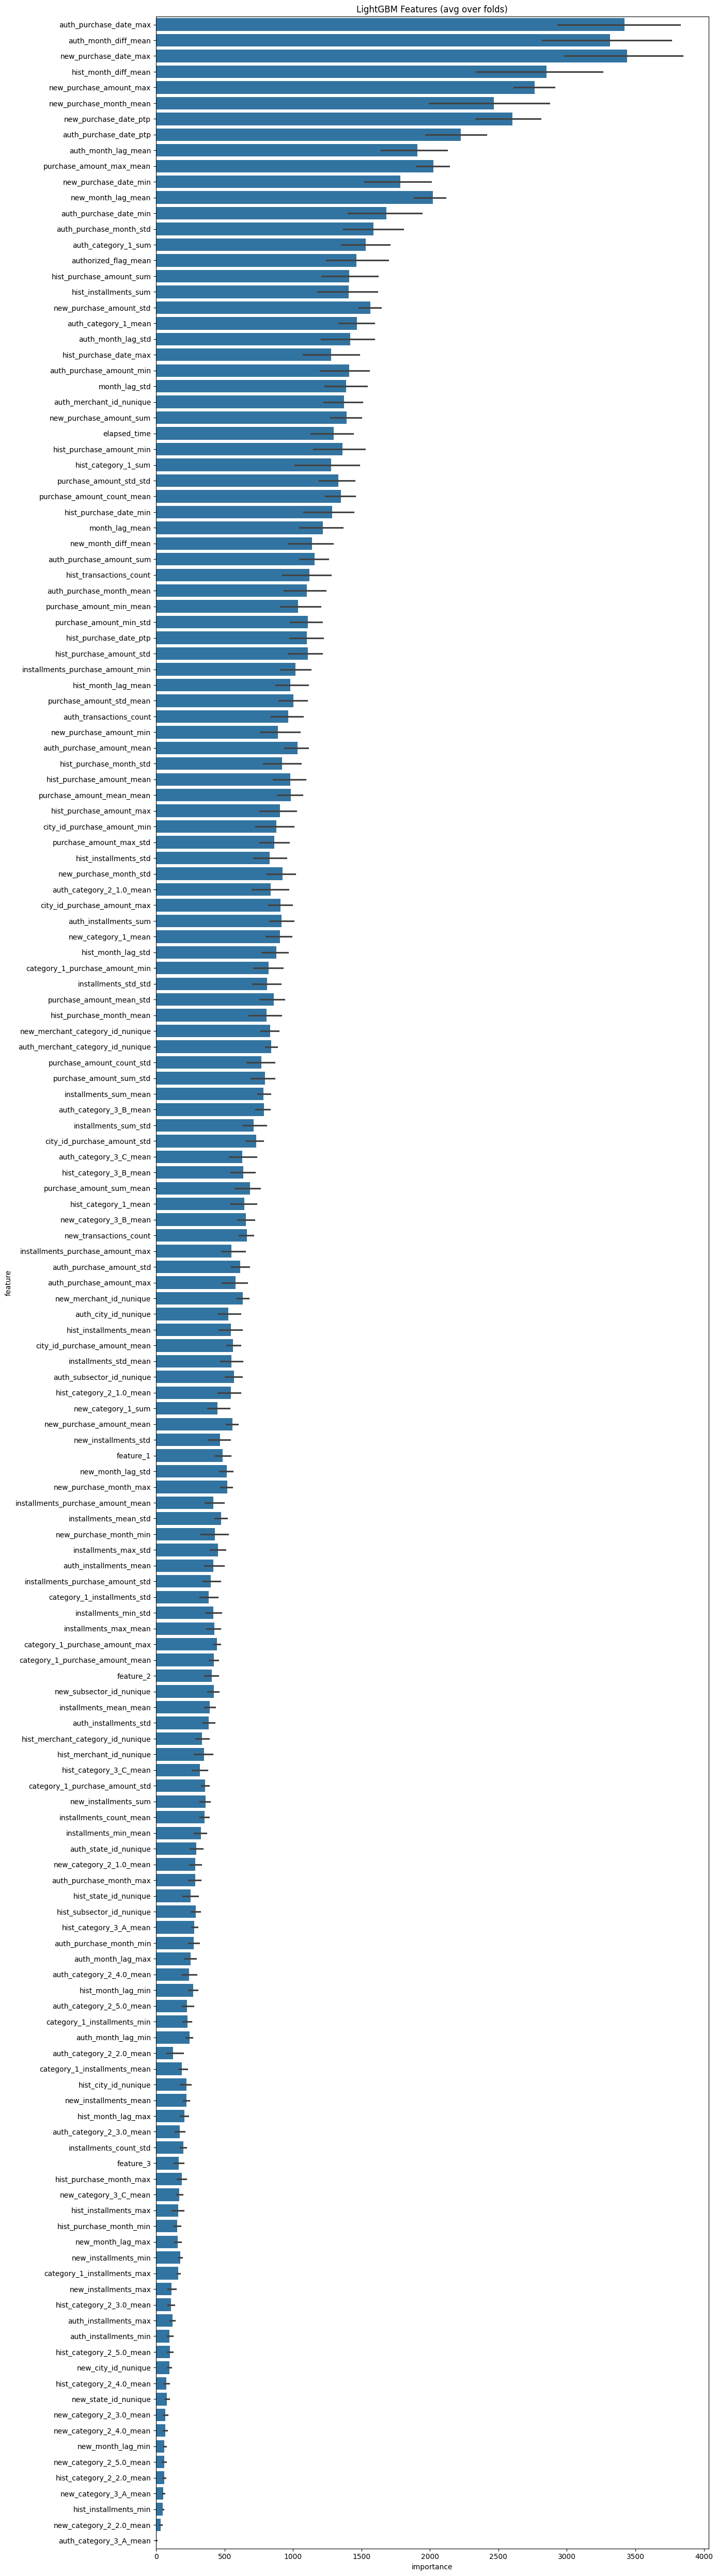

In [15]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')